# BitCoin Price Prediction

In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

c:\users\sumanth\anaconda2\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Use Quandl api to get BTC/USD data from kraken exchange

In [4]:
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1504 entries, 2014-01-07 to 2018-02-18
Data columns (total 7 columns):
Open                 1504 non-null float64
High                 1504 non-null float64
Low                  1504 non-null float64
Close                1504 non-null float64
Volume (BTC)         1504 non-null float64
Volume (Currency)    1504 non-null float64
Weighted Price       1504 non-null float64
dtypes: float64(7)
memory usage: 94.0 KB


In [6]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [7]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-02-14,8520.0,9520.6,8519.4,9489.7,7551.996538,6.885382e+07,9117.299676
2018-02-15,9475.7,10247.0,9330.1,10037.0,9682.242385,9.544926e+07,9858.177068
2018-02-16,10044.4,10325.1,9689.0,10188.5,6618.318567,6.642072e+07,10035.890399
2018-02-17,10188.5,11131.9,10056.7,11100.0,7380.937850,7.899228e+07,10702.200382
2018-02-18,11100.0,11308.8,10205.0,10577.0,8816.696595,9.490428e+07,10764.153936


Plot line graph base on Weighted Price

In [8]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

Fill value 0 data points on Weighted Price with NAN and then use ffill method to fill values¶

In [9]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

Plot new line graph again on Weighted Price with newly filled values

In [10]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

### Using Weighted Price as a feature to train the LSTM model

Use MinMaxScaler to normalize Weighted Price to range from 0 to 1

In [11]:
values = data['Weighted Price'].values
print(values)
print(values.shape)

[  841.8355223    839.15626937   831.57291257 ... 10035.89039947
 10702.20038219 10764.1539358 ]
(1504,)


In [12]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
print(values)
print(values.shape)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

[[  841.8355223 ]
 [  839.15626937]
 [  831.57291257]
 ...
 [10035.89039947]
 [10702.20038219]
 [10764.1539358 ]]
(1504, 1)
[[0.0339149 ]
 [0.03377341]
 [0.03337294]
 ...
 [0.51945215]
 [0.55463994]
 [0.5579117 ]]


Split 70% of data for training and 30% for testing

In [13]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1052 452


Create function for creating dataset with look back

In [14]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

Generate dataset for trainX, trainY, testX, testY

In [15]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1051
451


Reshape X for model training

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Running the LSTM model with 300 epochs

In [17]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Plot line graph to show amount loss according the the epoch¶

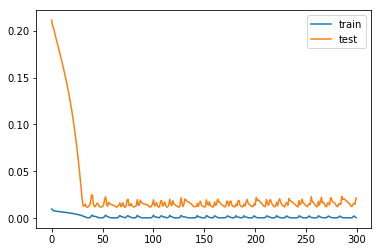

In [18]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Make prediction using textX and plotting line graph against testY

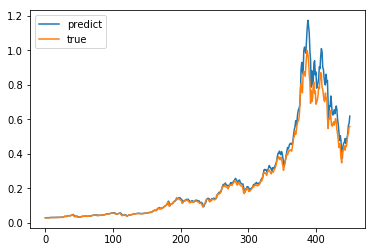

In [19]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

Scaler Inverse Y back to normal value

In [20]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

RMSE

In [21]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 890.668


Plot line graph with Y as USD

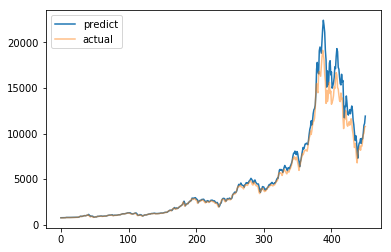

In [22]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

Convert X to dates

In [23]:
predictDates = data.tail(len(testX)).index

Reshape testY and yhat for plotly

In [24]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

Plot predicted and actual line graph with X=dates, Y=USD

In [25]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])